In [1]:
from PIL import Image
from matplotlib import image
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [3]:
img_gen = ImageDataGenerator(rescale=1./255)

In [4]:
train_data_gen = img_gen.flow_from_directory(directory='baseline/baseline_train/',
                                                    batch_size=20,
                                                    shuffle=False,
                                                    target_size=(596,1599),
                                                    class_mode='binary',
                                                    classes=['non_PL','PL'])
test_data_gen = img_gen.flow_from_directory(directory='baseline/baseline_test/',
                                                   batch_size=20,
                                                   shuffle=True,
                                                   target_size=(596,1599),
                                                   class_mode='binary',
                                                   classes=['non_PL','PL'])

Found 1814 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [15]:
img_test = train_data_gen[0][0]

In [6]:
for img in img_test:
    i = Image.fromarray(img, 'RGB')
    i.show()

In [5]:
img_test[0].shape

(596, 1599, 3)

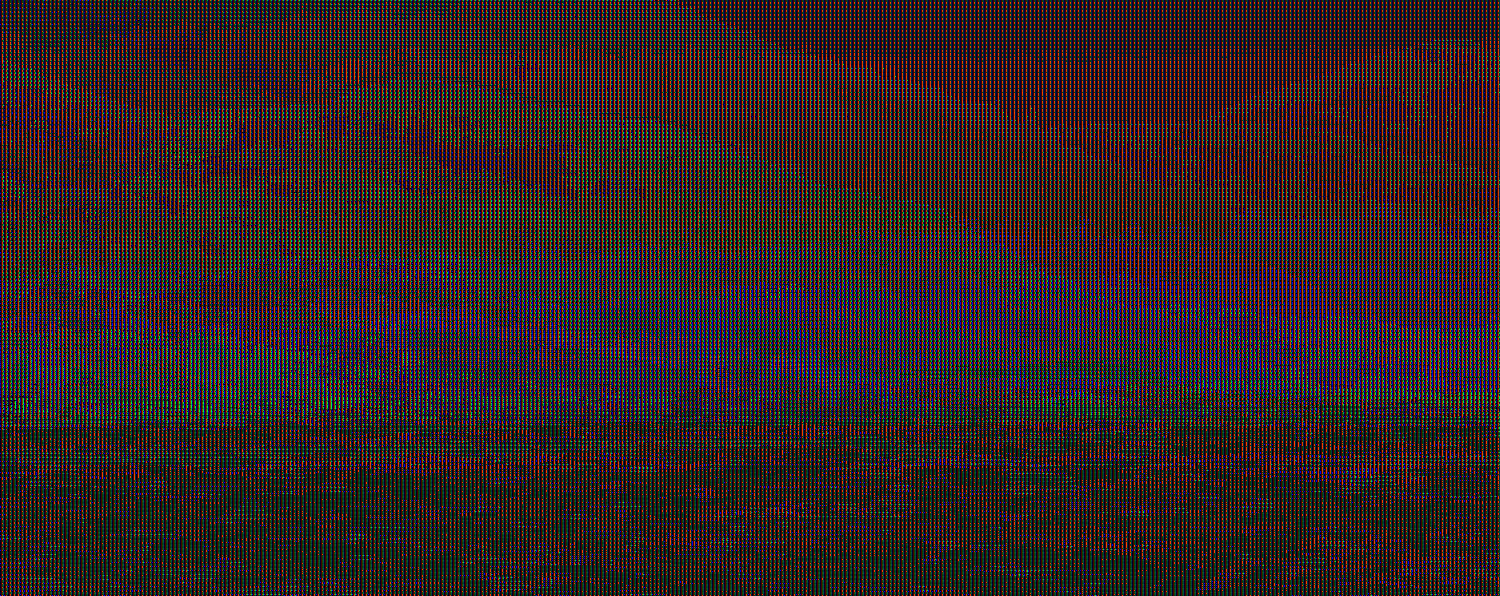

In [16]:
Image.fromarray(img_test[2], 'RGB')

In [ ]:
Image.fromarray(train_data_gen[0][0][18], 'RGB')


In [5]:
import os

In [6]:
checkpoint_prefix = os.path.join('model_checkpoints/', "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


In [12]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32,(8,8), activation='relu', input_shape=(596,1599,3)))
model.add(keras.layers.MaxPooling2D((3,3)))

In [13]:
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(2))

In [14]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 589, 1592, 32)     6176      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 196, 530, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3324160)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6648322   
Total params: 6,654,498
Trainable params: 6,654,498
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(train_data_gen, epochs=8,
                    validation_data=(test_data_gen[0],
                    callbacks=[checkpoint_callback])
                   )

  ...
    to  
  ['...']
Train for 76 steps, validate on 24 samples
Epoch 1/8
76/76 [==============================] - 265s 3s/step - loss: 19.1163 - accuracy: 0.7172 - val_loss: 2.0824 - val_accuracy: 0.5000
Epoch 2/8
76/76 [==============================] - 262s 3s/step - loss: 0.6811 - accuracy: 0.8556 - val_loss: 0.6930 - val_accuracy: 0.6667
Epoch 3/8
76/76 [==============================] - 261s 3s/step - loss: 0.3469 - accuracy: 0.9035 - val_loss: 0.4801 - val_accuracy: 0.8750
Epoch 4/8
76/76 [==============================] - 260s 3s/step - loss: 0.1624 - accuracy: 0.9531 - val_loss: 0.4078 - val_accuracy: 0.8750
Epoch 5/8
76/76 [==============================] - 261s 3s/step - loss: 0.0894 - accuracy: 0.9680 - val_loss: 0.6290 - val_accuracy: 0.8750
Epoch 6/8
76/76 [==============================] - 261s 3s/step - loss: 0.0461 - accuracy: 0.9862 - val_loss: 0.5296 - val_accuracy: 0.9167
Epoch 7/8
76/76 [==============================] - 261s 3s/step - loss: 0.0379 - accuracy: 

In [39]:
loss = history.history['loss']
accuracy = history.history['accuracy']

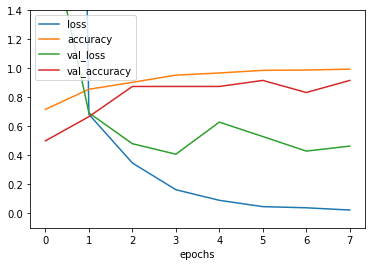

In [58]:
for key, value in history.history.items():
    plt.plot(value, label=key)
    plt.ylim(-.1,1.4)
    plt.legend()
    plt.xlabel('epochs')

In [ ]:
history2 = model.fit(train_data_gen, epochs=30,
                    validation_data=(test_data_gen[0])
                   )

  ...
    to  
  ['...']
Train for 76 steps, validate on 24 samples
Epoch 1/30
76/76 [==============================] - 259s 3s/step - loss: 35.5318 - accuracy: 0.6461 - val_loss: 1.5709 - val_accuracy: 0.5833
Epoch 2/30
76/76 [==============================] - 255s 3s/step - loss: 0.6130 - accuracy: 0.8264 - val_loss: 0.4428 - val_accuracy: 0.7917
Epoch 3/30
76/76 [==============================] - 255s 3s/step - loss: 0.3523 - accuracy: 0.9041 - val_loss: 0.5650 - val_accuracy: 0.7500
Epoch 4/30
76/76 [==============================] - 255s 3s/step - loss: 0.2386 - accuracy: 0.9520 - val_loss: 0.5947 - val_accuracy: 0.7500
Epoch 5/30
76/76 [==============================] - 255s 3s/step - loss: 0.1594 - accuracy: 0.9724 - val_loss: 0.5885 - val_accuracy: 0.7917
Epoch 6/30
76/76 [==============================] - 256s 3s/step - loss: 0.1177 - accuracy: 0.9802 - val_loss: 0.6782 - val_accuracy: 0.7500
Epoch 7/30
10/76 [==>...........................] - ETA: 3:50 - loss: 0.0800 - accura

In [16]:
history3 = model.fit(train_data_gen, epochs=8,
                    validation_data=(test_data_gen),
                    #callbacks=[checkpoint_callback]
                   )

  ...
    to  
  ['...']
Train for 91 steps, validate on 20 samples
Epoch 1/8
91/91 [==============================] - 259s 3s/step - loss: 1.1947 - accuracy: 0.7729 - val_loss: 1.5921 - val_accuracy: 0.6500
Epoch 2/8
91/91 [==============================] - 259s 3s/step - loss: 0.3613 - accuracy: 0.8947 - val_loss: 0.9819 - val_accuracy: 0.6500
Epoch 3/8
91/91 [==============================] - 259s 3s/step - loss: 0.2100 - accuracy: 0.9432 - val_loss: 0.7179 - val_accuracy: 0.6000
Epoch 4/8
91/91 [==============================] - 259s 3s/step - loss: 0.1499 - accuracy: 0.9664 - val_loss: 1.1813 - val_accuracy: 0.7000
Epoch 5/8
91/91 [==============================] - 259s 3s/step - loss: 0.1034 - accuracy: 0.9791 - val_loss: 0.4720 - val_accuracy: 0.8000
Epoch 6/8
91/91 [==============================] - 260s 3s/step - loss: 0.0854 - accuracy: 0.9829 - val_loss: 0.9906 - val_accuracy: 0.6500
Epoch 7/8
91/91 [==============================] - 260s 3s/step - loss: 0.0629 - accuracy: 0

In [10]:
history4 = model.fit(train_data_gen, epochs=8,
                    validation_data=(test_data_gen),
                    #callbacks=[checkpoint_callback]
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 91 steps, validate for 13 steps
Epoch 1/8
91/91 [==============================] - 277s 3s/step - loss: 29.9283 - accuracy: 0.6692 - val_loss: 1.9717 - val_accuracy: 0.7724
Epoch 2/8
91/91 [==============================] - 273s 3s/step - loss: 1.0843 - accuracy: 0.7977 - val_loss: 0.6347 - val_accuracy: 0.7642
Epoch 3/8
91/91 [==============================] - 272s 3s/step - loss: 0.2961 - accuracy: 0.9085 - val_loss: 0.6519 - val_accuracy: 0.7967
Epoch 4/8
91/91 [==============================] - 272s 3s/step - loss: 0.1532 - accuracy: 0.9504 - val_loss: 0.9238 - val_accuracy: 0.7602
Epoch 5/8
91/91 [==============================] - 272s 3s/step - loss: 0.0986 - accuracy: 0.9675 - val_loss: 0.6023 - val_accuracy: 0.8089
Epoch 6/8
91/91 [==============================] - 273s 3s/step - loss: 0.0661 - accuracy: 0.9829 - val_loss: 0.6021 - val_accuracy: 0.8008
Epoch 7/8
91/91 [==============================] - 273s 3s/step - l

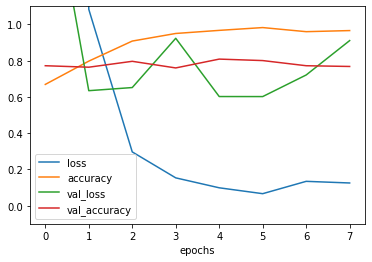

In [12]:
for key, value in history4.history.items():
    plt.plot(value, label=key)
    plt.ylim(-.1,1.1)
    plt.legend()
    plt.xlabel('epochs')

In [ ]:
history5 = model.fit(train_data_gen, epochs=15,
                    validation_data=(test_data_gen),
                    callbacks=[checkpoint_callback]
                   )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 91 steps, validate for 13 steps
Epoch 1/15
91/91 [==============================] - 774s 9s/step - loss: 15.0264 - accuracy: 0.5766 - val_loss: 0.6730 - val_accuracy: 0.6423
Epoch 2/15
91/91 [==============================] - 772s 8s/step - loss: 0.6452 - accuracy: 0.6830 - val_loss: 0.6359 - val_accuracy: 0.6504
Epoch 3/15
91/91 [==============================] - 772s 8s/step - loss: 0.5434 - accuracy: 0.7635 - val_loss: 0.6726 - val_accuracy: 0.6789
Epoch 4/15
91/91 [==============================] - 773s 8s/step - loss: 0.3746 - accuracy: 0.8754 - val_loss: 0.9141 - val_accuracy: 0.6545
Epoch 5/15
90/91 [============================>.] - ETA: 8s - loss: 0.2459 - accuracy: 0.9292 

In [24]:
model2 = keras.models.Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(596,1599,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(52, activation='relu'),
    Dense(1)
])

In [23]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 596, 1599, 16)     448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 298, 799, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 298, 799, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 399, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 149, 399, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 199, 64)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 942464)           

In [27]:
model.compile(optimizer='rmsprop')

ValueError: The model cannot be compiled because it has no loss to optimize.

In [25]:
history4 = model2.fit(train_data_gen, epochs=8,
                    validation_data=(test_data_gen),
                    callbacks=[checkpoint_callback]
                   )

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.